In [19]:
# Instalar e importar o Yahoo Finance (yfinance)
!pip install yfinance
import yfinance as yf

In [20]:
# Importar bibliotecas 
import pandas as pd
import numpy as np
import math
import torch
import matplotlib.pyplot as plt

In [21]:
# Exibir informações das ações da Petrobras
CS = yf.Ticker('CSNA3.SA')
print(CS.info)

{'zip': '04538-132', 'sector': 'Basic Materials', 'fullTimeEmployees': 23196, 'longBusinessSummary': 'Companhia SiderÃºrgica Nacional operates as an integrated steel producer in Brazil and Latin America. The company operates in five segments: Steel, Mining, Logistics, Energy, and Cement. It offers flat steel products, such as high, medium, low carbon, micro-alloyed, and interstitial free slabs; hot-rolled products, including heavy and light-gauge hot-rolled coils and sheets; cold-rolled products comprising cold-rolled coils and sheets; galvanized products; tin mill products that consist of flat-rolled low-carbon steel coils or sheets; and profiles, channels, UPE sections, and steel sleepers for the distribution, packaging, automotive, home appliance, and construction industries. The company primarily explores for iron ore reserves at Casa de Pedra and Engenho mines located in the city of Congonhas; and limestone and dolomite at the Bocaina mine located in the city of Arcos in the state

In [22]:
# Coletar dados da Petrobras
data = yf.download('CSNA3.SA', start='2016-01-01', end='2020-11-20')
print(data)
# data

[*********************100%***********************]  1 of 1 completed


In [23]:
#Coletar somente o fechamento diário
data = data.Close

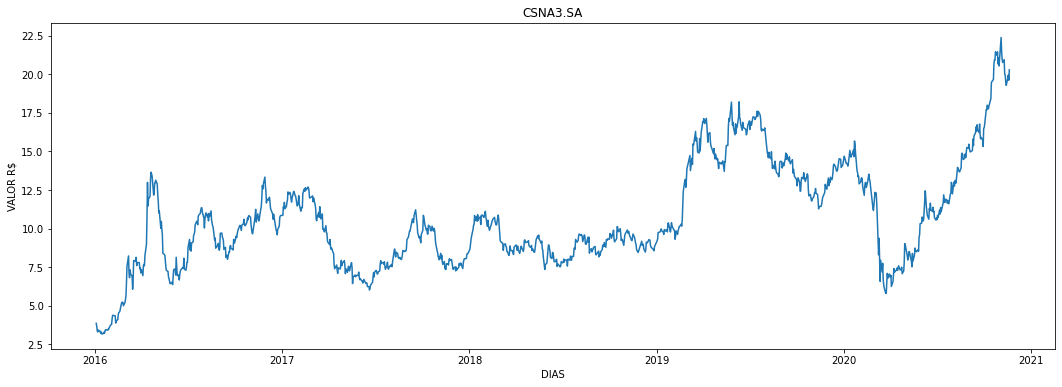

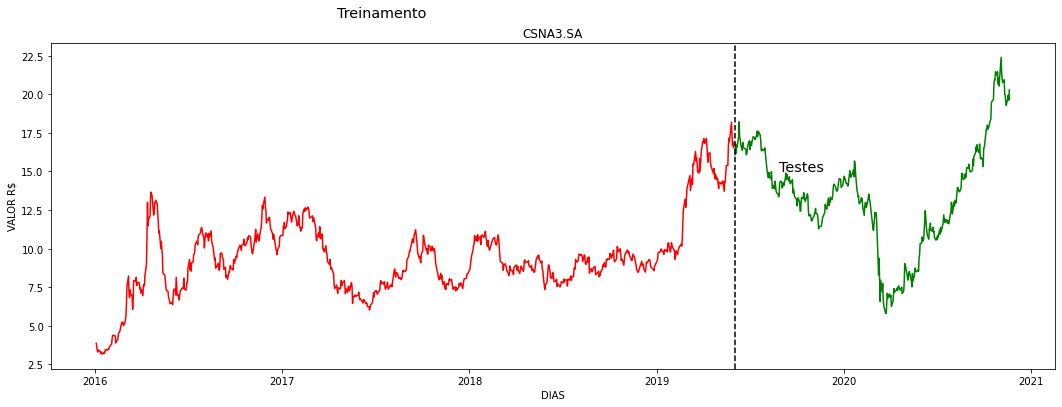

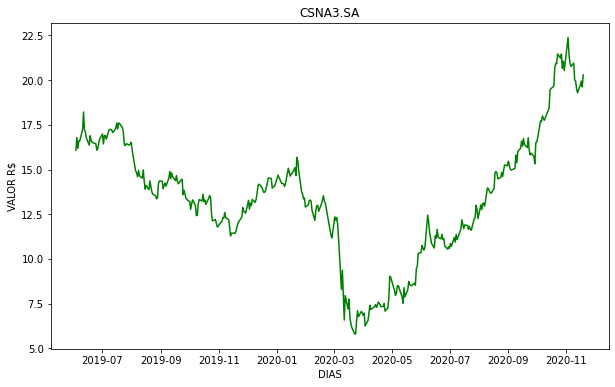

In [24]:
# Plotar o gráfico todo
plt.figure(figsize=(18, 6))
plt.plot(data, '-')
plt.xlabel('DIAS')
plt.ylabel('VALOR R$')
plt.title('CSNA3.SA')
plt.show()

# Plotar treinamento e teste
plt.figure(figsize=(18, 6))
plt.plot(data[:850], 'r-')
plt.plot(data[850:], 'g-')
plt.xlabel('DIAS')
plt.ylabel('VALOR R$')
plt.title('CSNA3.SA')
plt.axvline(data.index[850], 0, 30, color='k', linestyle='dashed', label='Teste')
plt.text(data.index[320], 25, 'Treinamento', fontsize='x-large')
plt.text(data.index[910], 15, 'Testes', fontsize='x-large')
plt.show()

# Plotar apenas teste
plt.figure(figsize=(10, 6))
plt.plot(data[850:], 'g-')
plt.xlabel('DIAS')
plt.ylabel('VALOR R$')
plt.title('CSNA3.SA')
plt.show()

In [25]:
# Criar janela deslizante
janelas = 50

data_final = np.zeros([data.size - janelas, janelas + 1])

for i in range(len(data_final)):
    for j in range(janelas+1):
        data_final[i][j] = data.iloc[i+j]
# print(data_final[:10])

In [26]:
# Normalizar entre 0 e 1
max = data_final.max()
min = data_final.min()
dif = data_final.max() - data_final.min()
data_final = (data_final - data_final.min())/dif

x = data_final[:, :-1]
y = data_final[:, -1]
# print(max, min, dif)

In [27]:
# Converter para tensor
#Entrada do treinamento
#Saída do treinamento
training_input = torch.FloatTensor(x[:850, :])
training_output = torch.FloatTensor(y[:850])

#Entrada do teste
#Saída do teste
test_input = torch.FloatTensor(x[850: , :])
test_output = torch.FloatTensor(y[850:])

# print(test_input)
# print(test_output)

In [28]:
# Classe do modelo da Rede Neural
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.relu(output)
        return output

In [29]:
# Criar a instância do modelo
input_size = training_input.size()[1]
hidden_size = 100
model = Net(input_size, hidden_size)
print(f'Entrada: {input_size}')
print(f'Escondida: {hidden_size}')
print(model)

Entrada: 50
Escondida: 100
Net(
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


In [30]:
# Critério de erro
criterion = torch.nn.MSELoss()

# Criando os paramêtros (learning rate[obrigatória] e momentum[opcional])
lr = 0.09 #0.01
momentum = 0.03 #0.01
optimizer = torch.optim.SGD(model.parameters(), lr, momentum)

In [31]:
# Para visualizar os pesos
for param in model.parameters():
  # print(param)
  pass

In [32]:
# Treinamento
model.train()
epochs = 1000
errors = []
for epoch in range(epochs):
  optimizer.zero_grad()
  # Fazer o forward
  y_pred = model(training_input)
  # Cálculo do erro
  loss = criterion(y_pred.squeeze(), training_output)
  errors.append(loss.item())
  if epoch % 1000 == 0:
    print(f'Epoch: {epoch}. Train loss: {loss.item()}.')
  # Backpropagation
  loss.backward()
  optimizer.step()

Epoch: 0. Train loss: 0.15072177350521088.


In [33]:
# Testar o modelo já treinado
model.eval()
y_pred = model(test_input)
after_train = criterion(y_pred.squeeze(), test_output)
print('Test loss after Training' , after_train.item())

Test loss after Training 0.001356189721263945


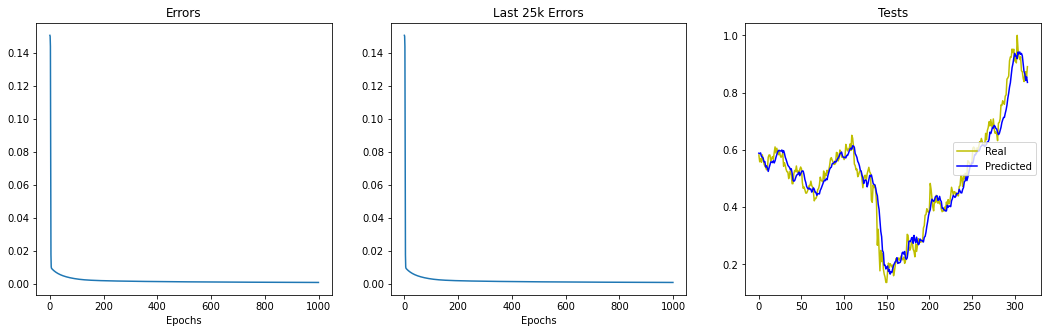

In [34]:
# Gráficos de erro e de previsão
def plotcharts(errors):
    errors = np.array(errors)
    lasterrors = np.array(errors[-25000:])
    plt.figure(figsize=(18, 5))
    graf01 = plt.subplot(1, 3, 1) # nrows, ncols, index
    graf01.set_title('Errors')
    plt.plot(errors, '-')
    plt.xlabel('Epochs')
    graf02 = plt.subplot(1, 3, 2) # nrows, ncols, index
    graf02.set_title('Last 25k Errors')
    plt.plot(lasterrors, '-')
    plt.xlabel('Epochs')
    graf03 = plt.subplot(1, 3, 3)
    graf03.set_title('Tests')
    a = plt.plot(test_output.numpy(), 'y-', label='Real')
    #plt.setp(a, markersize=10)
    a = plt.plot(y_pred.detach().numpy(), 'b-', label='Predicted')
    #plt.setp(a, markersize=10)
    plt.legend(loc=7)
    plt.show()
plotcharts(errors)

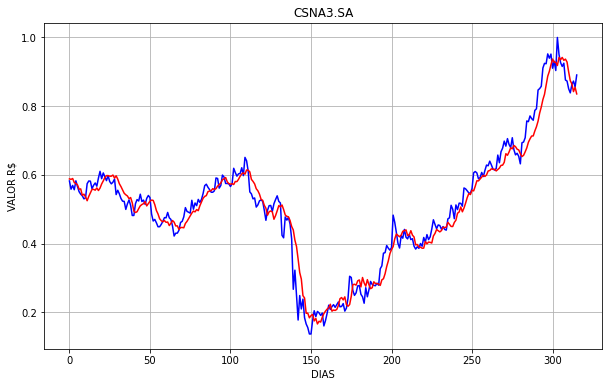

In [35]:
# Plotar detalhamento
plt.figure(figsize=(10, 6))
plt.plot(test_output.numpy(), 'b-') 
plt.plot(y_pred.detach().numpy(), 'r-')
plt.grid()
plt.xlabel('DIAS')
plt.ylabel('VALOR R$')
plt.title('CSNA3.SA')
plt.show()

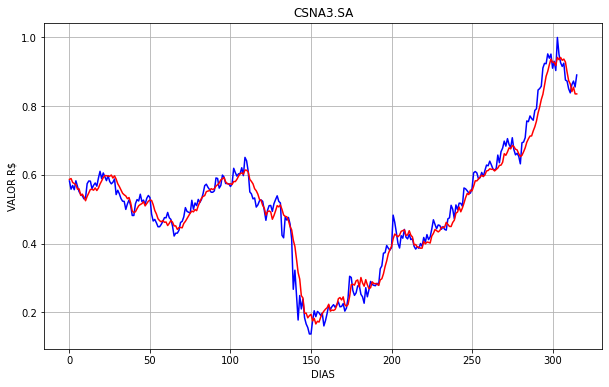

In [36]:
  #Roll
roll = torch.roll(y_pred, -1, 0)
roll[-1] = roll[-2]
# Plotar detalhamento
plt.figure(figsize=(10, 6))
plt.plot(test_output.numpy(), 'b-') 
plt.plot(roll.detach().numpy(), 'r-')
plt.grid()
plt.xlabel('DIAS')
plt.ylabel('VALOR R$')
plt.title('CSNA3.SA')
plt.show()